# 2024 인공지능 실습 2차시: Bayesian Network

2024년 5월 23일 목요일


학번/이름: 2022250030 / Gwendelyn Wong Rhien Yhung

목차:
*  Probability Distribution
  *  Joint probability distribution
  *  Inference using full joint distributions
*  Bayesian Network
  *  Inference
  *  Inference by Enumeration
*  Sampling
  *  Prior Sampling
  *  Rejection Sampling
  *  Likelihood Weighting
*  Markov chain
  *  Hidden Markov Models
* 실습 과제

In [ ]:
# 실습 패키지 설치 코드
!pip install pomegranate==0.14.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for pomegranate: filename=pomegranate-0.14.9-cp310-cp310-linux_x86_64.whl size=18331502 sha256=6cf3ad21c8c365c9e691a3da992fa77227efce8b240e4c20d10f75c9fbe752e7
  Stored in directory: /root/.cache/pip/wheels/14/e7/b2/189a2d351ac4ae073cfa17ce9d56936d59af5712a18028fc31
Successfully built pomegranate
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
# import statements
from pomegranate import *
from collections import Counter, defaultdict
import numpy as np

# Probability Distribution

In [ ]:
class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    """

    def __init__(self, varname='', freqs=None):
        """If freqs is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p)
                          for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.varname)

`ProbDist` class: discrete probability distributions을 정의
*  `__init__`: `ProbDist` 클래스의 생성자
  *  `varname`: 확률 변수의 이름을 나타내는 문자열
  *  `freqs`: 값-빈도 쌍의 딕셔너리
*  `__getitem__`: python class 기본 내장 getter method. 클래스 객체의 특정 키에 대한 값을 가져올 때 호출됨.
*  `__setitem__`: setter method. 클래스객 체의 특정 키에 대해 값을 설정할 때 호출됨.
*  `normalize`: 모든 값의 확률이 1이 되도록 정규화
*  `show_approx`: 키를 기준으로 정렬된 확률 값을 반올림하여 문자열 형식으로 표시
*  `__repr__`: 객체의 문자열 표현을 반환

$Flip = <H, T>$

$P(H) = 0.25$

$P(T) = 0.75$

In [ ]:
# 딕셔너리와 비슷하게 확률 변수와 확률 값을 지정
# given probability
p = ProbDist('Flip')
p['H'] = 0.25
p['T'] = 0.75
p['T']

0.75

$Scale = <low, medium, high>$

$Count(low) = 125$

$Count(medium) = 375$

$Count(high) = 500$

In [ ]:
# 생성자의 freqs 파라미터에 딕셔너리를 입력하여 생성
# given freq
p = ProbDist('Scale', freqs={'low':125, 'medium':375, 'high':500})


In [ ]:
# normalize 메소드가 적용되어 합이 1이 되도록 확률값이 정규화됨
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

In [ ]:
# 변수명 출력
p.varname

'Scale'

In [ ]:
# 확률 변수의 목록 접근
p.values

['low', 'medium', 'high']

$Animal = <Cat, Dog, Mice>$

$Count(Cat) = 50$

$Count(Dog) = 114$

$Count(Mice) = 64$

In [ ]:
# 확률 변수와 값이 점진적으로 추가되면 정규화가 적용되지 않음
p = ProbDist('Animal')
p['Cat'] = 50
p['Dog'] = 114
p['Mice'] = 64
(p['Cat'], p['Dog'], p['Mice'])

(50, 114, 64)

In [ ]:
# 정규화 메소드을 호출하여 정규화를 강제
p.normalize()
(p['Cat'], p['Dog'], p['Mice'])

(0.21929824561403508, 0.5, 0.2807017543859649)

In [ ]:
# 소수점까지의 근사치를 표시
p.show_approx()

'Cat: 0.219, Dog: 0.5, Mice: 0.281'

## Joint Probability Distribution

In [ ]:
class JointProbDist(ProbDist):
    """A discrete probability distribute over a set of variables."""

    def __init__(self, variables):
        self.prob = {}
        self.variables = variables
        self.vals = defaultdict(list)

    def __getitem__(self, values):
        """Given a tuple or dict of values, return P(values)."""
        values = event_values(values, self.variables)
        return ProbDist.__getitem__(self, values)

    def __setitem__(self, values, p):
        """Set P(values) = p.  Values can be a tuple or a dict; it must
        have a value for each of the variables in the joint. Also keep track
        of the values we have seen so far for each variable."""
        values = event_values(values, self.variables)
        self.prob[values] = p
        for var, val in zip(self.variables, values):
            if val not in self.vals[var]:
                self.vals[var].append(val)

    def values(self, var):
        """Return the set of possible values for a variable."""
        return self.vals[var]

    def __repr__(self):
        return "P({})".format(self.variables)

def event_values(event, variables):
    """Return a tuple of the values of variables in event.
    """
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])

`JointProbDist` class: 여러 변수에 대한 discrete probability distribution를 나타내는 클래스. ProbDist 클래스를 상속받음.
*  `__init__`: `JointProbDist` 클래스의 생성자
  *  `variables`: 확률 분포가 정의된 변수들의 리스트
*  `__getitem__`: 주어진 값들의 튜플이나 딕셔너리에 대해 결합 확률 P(values)를 반환
*  `__setitem__`: 주어진 값들의 튜플이나 딕셔너리에 대해 결합 확률 P(values)를 설정
*  `values`: 특정 변수에 대한 가능한 값들의 집합을 반환
*  `__repr__`: 객체의 문자열 표현을 반환
*  `event_values`: 주어진 이벤트(`event`)에서 특정 변수들(`variables`)의 값을 추출하여 튜플로 반환

$X = <0, 1>$

$Y = <1>$

$P(X=0, Y=1)=0.5$

$P(X=1, Y=1)=0.2$

In [ ]:
# Joint distribution를 지정하려면 먼저 변수의 순서가 지정된 list가 필요
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

In [ ]:
# 아래와 같은 방법으로 분포의 모든 가능한 값에 대해 확률을 할당
j[dict(X=0, Y=1)] = 0.5
j[1,1] = 0.2 # X = 1 & Y = 1

(j[0,1], j[1,1])

(0.5, 0.2)

In [ ]:
# values 메서드를 통해 특정 변수의 값을 출력
j.values('X')


[0, 1]

In [ ]:
# Y 변수값 출력
j.values('Y')

[1]

## Inference Using Full Joint Distributions

*  Full joint distribution을 사용하여 일부 evidence가 주어진 후의 posterior distribution을 계산
*  Evidence은 딕셔너리로 표현하며, 변수를 딕셔너리의 키로, 값을 딕셔너리의 값으로 표현
*  아래 식을 `enumerate_joint`와 `enumerate_joint_ask`으로 구현

<img src="https://cs50.harvard.edu/ai/2024/notes/2/inferencebyenumeration.png" width="600"/>

: 관찰된 evidence $e$와 일부 hidden variable $Y$가 주어졌을 때 쿼리 $X$의 확률 분포를 찾는 프로세스

  *  $\alpha$: 정규화 계수
  *  $X$: 쿼리
  *  $\textbf{e}$: evidence
  *  $\textbf{y}$: 쿼리나 evidence에 포함되지 않은 나머지 변수들

<img src="https://wikidocs.net/images/page/189106/Fig_12_03.PNG" width="600"/>

*  marginal probabilities:

capital C is both probs of cavity and not (distribution);
small c is only true;
comma is intercept

$$
\begin{aligned}
P(Cavity) &= P(Cavity,toothache,catch)+P(Cavity,toothache,¬catch)
+ P(Cavity,¬toothache,catch)+P(Cavity,¬toothache,¬catch) \\
&= ⟨0.108,0.016⟩+⟨0.012,0.064⟩+⟨0.072,0.144⟩+⟨0.008,0.576⟩ \\
&= ⟨0.2,0.8⟩
\end{aligned}
$$

*  conditional probabilities:

$$P(a|b) = \frac{P(a∧b)}{P(b)}$$

*  $P(Cavity|toothache)$:

$$
\begin{aligned}
P(cavity|toothache) &= \frac{P(cavity∧toothache)}{P(toothache)} \\
&= \frac{0.108 + 0.012}{0.108 + 0.012 + 0.016 + 0.064}  \\
&= 0.6
\end{aligned}
$$

$$
\begin{aligned}
P(¬cavity|toothache) &= \frac{P(¬cavity∧toothache)}{P(toothache)} \\
&= \frac{0.016 + 0.064}{0.108 + 0.012 + 0.016 + 0.064}  \\
&= 0.4
\end{aligned}
$$

따라서,

$$
\begin{aligned}
P(Cavity | toothache) &= α P(Cavity, toothache) \\
&= α[P(Cavity,toothache,catch)+P(Cavity,toothache,¬catch)] \\
&= α[⟨0.108,0.016⟩+⟨0.012,0.064⟩] \\
&= α⟨0.12,0.08⟩ \\
&=⟨0.6,0.4⟩.
\end{aligned}
$$

In [ ]:
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576

In [ ]:
def enumerate_joint(variables, e, P):
    """Return the sum of those entries in P consistent with e,
    provided variables is P's remaining variables (the ones not in e)."""
    if not variables:
        return P[e]
    Y, rest = variables[0], variables[1:]
    return sum([enumerate_joint(rest, extend(e, Y, y), P)
                for y in P.values(Y)]) # recursion

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

*  `enumerate_joint`: 주어진 변수들의 리스트와 evidence에 대해, joint probability distribution P에서 evidence와 일치하는 항목들의 합을 반환
  *  `variables`: 증거에 포함되지 않은 나머지 변수들의 리스트
  *  `e`: 딕셔너리 구조로 표현된 evidence
  *  `P`: `JointProbDist` 객체
* `extend`: 딕셔너리 `s`를 복사하면서, 새로운 항목 `{var: val}`을 추가하여 반환. `s`의 원본 상태를 변경하지 않고 확장된 딕셔너리를 생성

예제) $P(Toothache=True)$ ($P(toothache)$)


In [ ]:
# marginal probability
evidence = dict(Toothache=True)
variables = ['Cavity', 'Catch']
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

0.19999999999999998

예제) $P(Cavity=True 	\ and \ Toothache=True)$

In [ ]:
evidence = dict(Toothache=True, Cavity=True)
variables = ['Catch']
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

예제) $P(Cavity=True | Toothache = True) = \frac{P(Cavity=True \ and \ Toothache=True)}{P(Toothache=True)}$

In [ ]:
ans2/ans1

0.6

In [ ]:
def enumerate_joint_ask(X, e, P):
    """Return a probability distribution over the values of the variable X,
    given the {var:val} observations e, in the JointProbDist P.
    """
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)  # probability distribution for X, initially empty
    Y = [v for v in P.variables if v != X and v not in e]  # hidden variables.
    for xi in P.values(X):
        Q[xi] = enumerate_joint(Y, extend(e, X, xi), P)
    return Q.normalize()

*  `enumerate_joint_ask`: 주어진 evidence `e`에 대해 쿼리 `X`의 값들에 대한 확률 분포를 반환. Full joint probability distribution `P`를 사용하여 계산
  *  `X`: 쿼리
  *  `e`: 딕셔너리 구조로 표현된 evidence
  *  `P`: `JointProbDist` 객체

예제) $P(Cavity | Toothache=True)$


In [ ]:
query_variable = 'Cavity'
evidence = dict(Toothache=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
(ans[True], ans[False])

(0.6, 0.39999999999999997)

# Bayesian Network

*   베이지안 네트워크: 변수들 간의 **independence**와 conditional independence relationship을 포함한 full joint probability distribution의 표현하는 구조

*   베이지안 네트워크의 속성:
  *   방향성 그래프
  *   그래프의 각 노드는 랜덤 변수를 나타냄
  *   $X$에서 $Y$로 향하는 화살표는 $X$가 $Y$의 부모임을 나타냄. $Y$의 확률 분포는 $X$의 값에 따라 달라짐.
  *   각 노드 X는 확률 분포 $P(X|Parents(X))$을 가짐.

### Bayesian Network의 변수 간 independence 표현

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSa6Ed8rgFFOZCpVzvcF7oYXHnxSorWffnCZfr9Jhxmtw&s" width="400"/>



*  베이지안 네트워크의 topology(위상 구조)은 conditional independence relationship을 지정
  *  화살표의 의미: X가 Y에게 직접적인 영향을 미침
*  위 베이지안 네트워크에서 independence 관계:
  *  Weather은 다른 변수들과 독립적이다. (Weather is independent of the other variables.)
  *  Cavity가 주어졌을 때, Toothache와 Catch은 조건부 독립적이다. (Toothache and Catch are conditionally independent, given Cavity.)
*  여기서 conditional independence은 Toothache와 Catch 사이 **edge가 존재하지 않음**으로써 표현됨.
*  왜 independence 관계가 중요한가?
  *  두 이벤트가 서로에 영향을 미치지 않는다고 가정함으로써 계산을 단순화
  * Weather = {sun,rain,cloud,snow}이 다른 변수들과 independent하지 않을 때:
    * full joint distribution table의 디멘션: 2 * 2 * 2 * 4 = 32개의 row
  * Weather이 다른 변수들과 independent할 때:
    * full joint distribution table의 디멘션: Weather 변수 4개의 row, 나머지 변수 8개의 row

예제)

낚시를 하지 않는 사람이 있다. 이 사람은 호수에서 낚시를 하기에 좋은 날($F$)이 무엇인지 알고 싶어한다. 그러나 이 사람은 물고기를 한마리도 잡지 못했음에도 불구하고 좋은 날이 될 수 있다는 현상을 이해하지 못한다. 이 현상을 이해하기 위하여 세 가지 변수를 가진 베이지안 모델을 만들기로 한다. 베이지안 네트워크의 세 가지 변수는 비가 내렸는지($R$), 잡은 물고기의 양($C$), 바람이 불었는지($W$) 이다.

W,C,R should point to F
not actually conditionally independent, rain would affect wind and vice versa

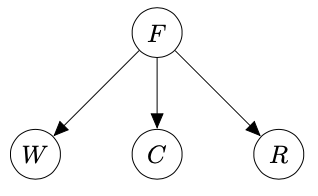

*  $F = <true, false>$
*  $R = <true, false>$
*  $C = <none, some, lots>$
*  $W = <true, false>$

## Bayesian Network example

<img src="https://cs50.harvard.edu/ai/2024/notes/2/bayesiannetwork.png" width="600"/>

*  Rain: 네트워크의 루트 노드
  *  확률 분포가 이전 사건에 의존하지 않음을 의미
  *  Rain은 다음 확률 분포를 사용하여 { none, light, heavy } 값을 취할 수 있는 무작위 변수

<div align="center">

| none | light | heavy |
| --- | --- | ---|
| 0.7  | 0.2 | 0.1 |

</div>

*  Maintenance: { yes, no } 값을 사용하여 열차 선로 유지 관리가 있는지 여부를 인코딩
  *  Rain은 Maintenance의 상위 노드이며 이는 Maintenance의 확률 분포가 Rain의 영향을 받음을 의미

<div align="center">

| Rain | yes | no|
| -- | -- | -- |
| none | 0.4 | 0.6 |
| light | 0.2 | 0.8 |
| heavy | 0.1 | 0.9 |

</div>

*  Train: 열차가 정시에 도착하는지 지연되는지 여부를 인코딩하는 변수로, { on time, delayed } 값을 사용
  *  Maintenance와 Rain의 값이 Train의 확률 분포에 영향을 미침

<div align="center">

| Rain | Maintenance | on time | delayed |
| -- | -- | -- | -- |
| none | yes | 0.8 | 0.2 |
| none | no | 0.9 | 0.1 |
| light | yes | 0.6 | 0.4 |
| light | no | 0.7 | 0.3 |
| heavy | yes | 0.4 | 0.6 |
| heavy | no | 0.5 | 0.5 |

</div>

*  Appointment: 약속 참석 여부를 나타내는 무작위 변수로, { attend, miss } 값을 사용
  *  유일한 부모는 Train.

<div align="center">

| Train | attend | miss |
| -- | -- | -- |
| on time | 0.9 | 0.1 |
| delayed | 0.6 | 0.4 |

</div>

*  베이지안 네트워크의 부모 영향:  
  *  부모에는 직접적인 관계만 포함됨. Maintenance은 Train이 on time인지에 대한 영향을 미치고, on time인 Train은 Appointment에 영향을 미침. 그러나 Appointment 확률에 직접적인 영향을 미치는 것은 Train의 확률이며, 이것이 베이지안 네트워크에 표현됨.
  *  예) Train이 on time이라면 Rain이 heavy이고 Maintenance가 yes일 수 있지만, Appointment가 attend일지 miss일지에 대한 영향은 없음.

예시) $P( light , no, delayed, miss )$
*  유지 보수가 없고 약간의 비가 내리는 날 기차가 연착되었을 때 회의를 놓칠 확률
  *  다음을 계산: $P(light)P(no | light)P(delayed | light, no)P(miss | delayed)$
  *  각 개별 확률의 값은 위의 확률 분포에서 찾을 수 있음

## Bayesian Network Inference


베이지안 네트워크 inference의 속성

*   Query $X$ : 확률 분포를 계산하려는 변수
*   Evidence $E$ : Event $e$ 에 대해 관찰된 하나 이상의 변수
  *   light rain임을 관찰했을 때, 이는 Train변수의 on time/delayed 확률 계산에 도움이 됨
*   Hidden variables $Y$ : 쿼리가 아니며 관찰되지 않은 변수
  *   light rain임을 관찰했을 때, maintenance이 실행중인지는 알 수 없음. 따라서 이 상황에서는 maintenance이 hidden variable
*   The goal: $P ( X | e )$을 계산
  *   light rain이라는 evidence $e$ 을 바탕으로 Train 변수(query)의 확률 분포를 계산



베이지안 네트워크를 [pomegranate](https://pomegranate.readthedocs.io/en/latest/) 라이브러리를 통해 구현:

In [ ]:
# Rain node has no parents
rain = Node(DiscreteDistribution({
    "none": 0.7,
    "light": 0.2,
    "heavy": 0.1
}), name="rain")
rain.distribution.name = 'rain'

# Track maintenance node is conditional on rain
maintenance = Node(ConditionalProbabilityTable([
    ["none", "yes", 0.4],
    ["none", "no", 0.6],
    ["light", "yes", 0.2],
    ["light", "no", 0.8],
    ["heavy", "yes", 0.1],
    ["heavy", "no", 0.9]
], [rain.distribution]), name="maintenance")

# Train node is conditional on rain and maintenance
train = Node(ConditionalProbabilityTable([
    ["none", "yes", "on time", 0.8],
    ["none", "yes", "delayed", 0.2],
    ["none", "no", "on time", 0.9],
    ["none", "no", "delayed", 0.1],
    ["light", "yes", "on time", 0.6],
    ["light", "yes", "delayed", 0.4],
    ["light", "no", "on time", 0.7],
    ["light", "no", "delayed", 0.3],
    ["heavy", "yes", "on time", 0.4],
    ["heavy", "yes", "delayed", 0.6],
    ["heavy", "no", "on time", 0.5],
    ["heavy", "no", "delayed", 0.5],
], [rain.distribution, maintenance.distribution]), name="train")

# Appointment node is conditional on train
appointment = Node(ConditionalProbabilityTable([
    ["on time", "attend", 0.9],
    ["on time", "miss", 0.1],
    ["delayed", "attend", 0.6],
    ["delayed", "miss", 0.4]
], [train.distribution]), name="appointment")

In [ ]:
# Create a Bayesian Network and add states
model = BayesianNetwork()
model.add_states(rain, maintenance, train, appointment)

# Add edges connecting nodes
model.add_edge(rain, maintenance)
model.add_edge(rain,train)
model.add_edge(maintenance, train)
model.add_edge(train, appointment)

# Finalize model
model.bake()

예제) 비가 내리지 않고, 선로 유지 관리가 없고, 기차가 정시에 운행하고, 회의에 참석할 확률

In [ ]:
# Calculate joint probability for a given observation
model.probability([['none', 'no', 'on time', 'attend']])

0.34019999999999995

예제) $Train = delayed$ 일 때, $Rain$, $Maintenance$, $Appointment$의 확률 분포

In [ ]:
# Calculate predictions based on the evidence that the train was delayed
# 주어진 evidence을 바탕으로 그래프 내 각 변수의 marginal probability distribution 계산
predictions = model.predict_proba({
    'train':'delayed'
})

In [ ]:
# Print predictions for each node
for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

rain
    none: 0.4583
    light: 0.3069
    heavy: 0.2348
maintenance
    no: 0.6432
    yes: 0.3568
train: delayed
appointment
    miss: 0.4000
    attend: 0.6000


*   inference by enumeration은 모델에 많은 변수들이 있는 경우에 비효율적
*   이와 같은 방식을 사용하는 exact inference 대신 sampling와 같은 approximate inference은 계산된 확률의 정밀도는 떨어지나 이는 무시할 수 있는 수준이며, 확장 가능한 확률 계산 방법

# Sampling

## Prior / Forward Sampling

*   Approximate inference 중 하나의 접근 방법이며, 각 변수가 확률 분포에 따른 값으로 샘플링됨.

  > 주사위를 사용한 샘플링을 사용하여 분포를 생성하려면 주사위를 여러 번 굴리고 매번 얻은 값을 기록할 수 있다. 주사위를 600번 굴렸다고 가정해 보았을 때. 1이 나온 횟수를 세고 나머지 값인 2~6에 대해 반복한다. 그런 다음 각 개수를 주사위를 굴린 총 횟수로 나눈다. 이는 주사위를 굴리는 값의 대략적인 분포를 생성한다. 각 값이 1/6의 발생 확률(정확한 확률)을 갖는 결과를 얻을 가능성은 없지만 그것에 가까운 값을 얻을 수 있다.

*   베이지안 네트워크에서 topological order으로 샘플링
    *   네트워크의 루트 노드에서 시작하여 $P(X_i | parent(X_i))$에 따라 샘플링
    *   값이 샘플링되는 확률 분포는 변수의 부모에게 이미 할당된 값에 따라 condition이 지정됨
    
*  순서: $Rain → Maintenance → Train → Appointment$

  * Prior sample 생성 예시:
    *   $P(Rain) = <0.7, 0.2, 0.1>$에서 샘플. $light$이 샘플됨
    *   $P(Maintenance|Rain=light) = <0.2, 0.8>$에서 샘플. $no$가 샘플됨.
    *  $P(Train|Maintenance=no,Rain=light) = <0.7, 0.3>$에서 샘플. $on \ time$이 샘플됨.
    *  $P(Appointment|Train=on \ time) = <0.9, 0.1>$에서 샘플. $attend$가 샘플됨
  * 샘플된 이벤트: $[light, no, on \ time, attend]$

In [ ]:
def generate_sample():

    # Mapping of random variable name to sample generated
    sample = {}

    # Mapping of distribution to sample generated
    parents = {}

    # Loop over all states, assuming topological order
    for state in model.states:

        # If we have a non-root node, sample conditional on parents
        if isinstance(state.distribution, ConditionalProbabilityTable):
            sample[state.name] = state.distribution.sample(parent_values=parents)

        # Otherwise, just sample from the distribution alone
        else:
            sample[state.name] = state.distribution.sample()

        # Keep track of the sampled value in the parents mapping
        parents[state.distribution] = sample[state.name]

    # Return generated sample
    return sample

In [ ]:
generate_sample()

{'rain': 'none',
 'maintenance': 'yes',
 'train': 'on time',
 'appointment': 'attend'}

예제) 10000개의 샘플로부터 $P(Train=on \ time)$ 계산

In [ ]:
# prior sample
N = 10000
all_observations = [generate_sample() for x in range(N)]

In [ ]:
train_on_time = [observation for observation in all_observations if observation['train']=='on time']

In [ ]:
# P( train = on time )
len(train_on_time) / N

0.7895

예제) $P( Rain = light | Train = on \ time )$

In [ ]:
rain_and_train = [observation for observation in train_on_time if observation['rain']=='light']

In [ ]:
answer = len(rain_and_train) / len(train_on_time)
print(answer)

0.17036098796706775


## Rejection Sampling

*  Rejection Sampling: 네트워크에서 표현된 prior distribution에서 샘플을 생성하고 evidence와 일치하지 않는 모든 샘플들을 reject함.
  *  쿼리를 미리 알고 있을 때 유용하며, prior sampling은 일반적으로 모든 쿼리에 대해 작동하지만 일부 상황에서는 실패할 수 있음.
* 베이지안 네트워크와 evidence $e$가 있는 상황에서, evidence $e$가 $True$일 때 변수 A가 $True$일 확률(몇 번 참인지)을 알고 싶은 상황
  *  Prior sampling으로 계산할 수 있으나, 실제 확률 분포에서 evidence $e$가 $True$일 확률은 매우 작다고 가정
  *  이러한 상황에서 샘플링은 e가 $True$인 데이터 점을 샘플링하지 못할 수 있으며, 샘플된 데이터에 $e$가 $True$인 경우가 없으면 $P(e) = 0$이므로 $P(A | e) / P(e) = 0/0$이 되어 계산을 할 수 없게 됨.

*  샘플하는 횟수를 늘릴 수는 있지만, $e$가 $0$이 아닌 경우가 존재한다는 것을 보장할 수는 없음. 이를 보장하기 위해서는 각 변수의 확률을 나타내는 데이터 points을 고려해야 하는데, 이는 approximate inference가 제공하는 속도 이점을 상실하고 베이지안 네트워크의 정확한 추론 모델을 계산해야 한다는 것을 의미함.

*  네트워크에서 샘플링하는 동안 주어진 쿼리의 evidence 변수와 일치하지 않는 샘플은 reject (evidence 변수에 해당하는 샘플만 고려)

예제) $P( Appointment | Train = delayed ) $

In [ ]:
# Rejection sampling
N = 10000
data = []

for i in range(N):
  sample = generate_sample()
  if sample["train"] == "delayed": # only append for evidence we want
    data.append(sample["appointment"])

print(Counter(data))

Counter({'attend': 1274, 'miss': 867})


In [ ]:
# normalize
x = Counter(data)
total = sum(x.values(), 0.0)
for key in x:
  x[key] /= total

print(x)

Counter({'attend': 0.595049042503503, 'miss': 0.40495095749649695})


## Likelihood Weighting

*  Rejection sampling의 한계: Limitations of Resection sampling:
  *  주어진 evidence와 일관된 샘플들을 찾을 확률이 낮을 때 rejection sampling을 실행하는 데 오랜 시간이 걸림 Rejection sampling takes a long time to run when the probability of finding samples consistent with the given evidence is low
  *  베이지안 네트워크가 크거나 evidence 변수들의 수가 많을 때도 오랜 시간이 걸림.  It takes a long time even when the Bayesian network is large or the number of evidence variables is large.
  *  rejection sampling은 evidence가 많은 변수로 구성된 경우 많은 표본을 reject하는 경향이 있음. Rejection sampling tends to reject many samples when evidence consists of many variables.
  
*  Likelihood weighting는 evidence을 고정하고 (evidence에 해당하는 표본을 추출하지 않음) 가중치를 사용하여 전체 표본이 여전히 일관성을 유지하도록 함으로써 rejection sampling의 한계를 극복함. Likelihood weighting overcomes the limitations of resection sampling by fixing the evidence (no sample corresponding to the evidence) and using weights to ensure that the entire sample is still consistent.

순서: $Rain → Maintenance → Train → Appointment$

*  예제) $P( Train | Rain=light, Maintenance=yes )$에 대한 likelihood sampling 예시
  *  weight $w$을 1.0으로 설정
  *  $Rain$은 $light$의 값을 가진 evidence 변수임. 따라서 샘플링 하지 않고 weight 업데이트
    *  $w \leftarrow w \times P(Rain=light) = 0.2$
  *  $Maintenance$ 또한 $yes$ 값을 가진 evidence 변수임. 샘플링 하지 않고 weight 업데이트
    *  $w \leftarrow w \times P(Maintenance=yes|Rain=light) = 0.2 \times 0.2 = 0.04$
  *  $Train$은 evidence 변수가 아님. $P(Train|Rain=light, Maintenance=yes)=<0.6	, 0.4>$에서 샘플링. $on \ time$이 샘플됨.
  *  $Appointment$은 evidence 변수가 아님. $P(Appointment|Train=on \ time)=<0.9, 	0.1>$에서 샘플링. $attend$가 샘플됨.
*  생성된 event와 weight: $[light, yes, on\ time, attend], 0.04$이며, $Train=on \ time$에 해당하는 샘플이 가중치 0.04로 샘플됨을 의미함.

In [ ]:
parents_model = {'maintenance':['rain'], 'train':['rain', 'maintenance'], 'appointment':['train']}

def generate_weighted_sample(evidence):
    # Mapping of random variable name to sample generated
    sample = {}
    weight = 1.0

    # Mapping of distribution to sample generated
    parents = {}

    # Loop over all states, assuming topological order
    for state in model.states:
        # If the state is in the evidence, use the observed value
        if state.name in evidence:
            sample[state.name] = evidence[state.name]

            # Update the weight based on the probability of the observed value
            if isinstance(state.distribution, ConditionalProbabilityTable):
                prob = state.distribution.probability([sample[parent] for parent in parents_model[state.name]] + [evidence[state.name]])
            else:
                prob = state.distribution.probability(evidence[state.name])
            weight *= prob

        # Otherwise, sample the value
        else:
            if isinstance(state.distribution, ConditionalProbabilityTable): # not root node
                sample[state.name] = state.distribution.sample(parent_values=parents)
            else: # root node
                sample[state.name] = state.distribution.sample()

        # Keep track of the sampled value in the parents mapping
        parents[state.distribution] = sample[state.name]

    # Return generated sample and its weight
    return sample, weight

예제) 쿼리 $P( Train | rain=light, maintenance=yes )$에 대한 weighted sample 생성

In [ ]:
evidence = {'rain':'light', 'maintenance':'yes'}
generate_weighted_sample(evidence)

({'rain': 'light',
  'maintenance': 'yes',
  'train': 'on time',
  'appointment': 'attend'},
 0.04000000000000001)

예제) 쿼리 $P( Appointment | Train = delayed )$을 likelihood weighting으로 계산

In [ ]:
N = 10000
weighted = {'attend':0, 'miss':0}
evidence = {'train':'delayed'}

for i in range(N):
  sample, weight = generate_weighted_sample(evidence)
  if sample['train'] == 'delayed':
    weighted[sample['appointment']] += weight

print(weighted)

{'attend': 1275.2999999999956, 'miss': 873.2000000000264}


In [ ]:
# normalize
x = weighted
total = sum(x.values(), 0.0)
for key in x:
  x[key] /= total
print(x)

{'attend': 0.5935769141261265, 'miss': 0.40642308587387366}


# Markov chain

*  Markov chain: 각 변수의 분포가 Markov 가정을 따르는 일련의 무작위 변수이며, 체인의 각 이벤트는 이전 이벤트의 확률에 따라 발생함.
*  전환 모델(transition model): 현재 이벤트의 가능한 값을 기반으로 다음 이벤트의 확률 분포를 지정, Markov chain 구성을 위해 필요함.

<img src="https://cs50.harvard.edu/ai/2024/notes/2/transitionmodel.png" width="600"/>

*  날씨 예시:
  *  오늘 맑을 때 내일 맑을 확률: 0.8
  *  오늘 맑을 때 내일 배가 올 확률: 0.2
  *  오늘 비가 온다면 내일 비가 올 확률: 0.7
  *  오늘 비가 온다면 내일 맑을 확률: 0.3

*  Transition model을 사용하여 Markov chain을 샘플링
  *  비가 오거나 맑은 날로 시작한 다음, 오늘 날씨를 고려하여 맑거나 비가 올 확률을 기준으로 다음 날을 샘플링
  *  내일을 기준으로 내일 모레의 확률을 조건으로 지정하여 마르코프 체인을 생성

<img src="https://cs50.harvard.edu/ai/2024/notes/2/markovchain.png" width="600"/>

In [ ]:
# Define starting probabilities
start = DiscreteDistribution({
    "sun": 0.5,
    "rain": 0.5
})

# Define transition model
transitions = ConditionalProbabilityTable([
    ["sun", "sun", 0.8],
    ["sun", "rain", 0.2],
    ["rain", "sun", 0.3],
    ["rain", "rain", 0.7]
], [start])

In [ ]:
# Create Markov chain
markov_model = MarkovChain([start, transitions])
# Sample 50 states from chain
print(markov_model.sample(50))

['rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'sun', 'sun', 'sun', 'sun', 'sun', 'rain', 'rain', 'sun', 'sun', 'sun', 'rain', 'rain', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'rain', 'rain', 'rain', 'sun', 'rain', 'rain', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'sun', 'rain']


## Hidden Markov Models


*  Hidden markov model: 관찰된 이벤트를 생성하는 hidden state을 갖는 시스템에 대한 Markov model의 한 유형
  *  세계에 대한 일부 관찰을 갖고 있지만 세계의 정확한 상태에 접근할 수 없다는 것을 표현
  *  이러한 경우 세계의 상태를 hidden state 라고 하며 액세스할 수 있는 모든 데이터는 observations이라고 함.
  *  Sensor model: hidden state와 observation의 확률을 나타냄

<img src="https://cs50.harvard.edu/ai/2024/notes/2/sensormodel.png" width="600"/>

*  날씨 예시:
  *  날씨가 맑으면 사람들이 건물에 우산을 가져오지 않을 가능성이 높음
  *  비가 오면 사람들이 우산을 건물로 가져올 가능성이 높음
*  사람들이 우산을 가지고 왔는지 아닌지를 관찰함으로써 바깥 날씨가 어떤지 확률로 예측

<img src="https://cs50.harvard.edu/ai/2024/notes/2/hiddenmarkovchain.png" width="600"/>

*  Hidden markov model은 두 개의 레이어가 있는 마르코프 체인으로 표현됨
*  위쪽 레이어인 변수 X는 hidden state을 나타내며 아래 레이어인 변수 E는 evidence, 관찰한 내용을 나타냄

In [ ]:
# Observation model for each state
sun = DiscreteDistribution({
    "umbrella": 0.2,
    "no umbrella": 0.8
})

rain = DiscreteDistribution({
    "umbrella": 0.9,
    "no umbrella": 0.1
})

states = [sun, rain]

# Transition model
transitions = np.array(
    [[0.8, 0.2], # Tomorrow's predictions if today = sun
     [0.3, 0.7]] # Tomorrow's predictions if today = rain
)

# Starting probabilities
starts = np.array([0.5, 0.5])

In [ ]:
# Create the model
hidden_markov_model = HiddenMarkovModel.from_matrix(
    transitions, states, starts,
    state_names=["sun", "rain"]
)
hidden_markov_model.bake()

In [ ]:
# 사람들이 건물에 우산을 가져왔는지 여부에 대한 일련의 관찰을 확인
observations = [
    "umbrella",
    "umbrella",
    "no umbrella",
    "umbrella",
    "umbrella",
    "umbrella",
    "umbrella",
    "no umbrella",
    "no umbrella"
]

# 위 시퀀스를 기반으로 모델을 실행하여 가장 가능성 있는 예측(가장 가능성이 높은 날씨 시퀀스)을 생성
predictions = hidden_markov_model.predict(observations)
for prediction in predictions:
    print(hidden_markov_model.states[prediction].name)

rain
rain
sun
rain
rain
rain
rain
sun
sun


# 실습 과제

## 1번

**[코드 작성]**

실습 내용을 바탕으로 아래 확률이 계산됨을 보이시오.


a. $P(\neg toothache) = 0.8$

b. $P(Cavity) = ⟨0.2, 0.8⟩ $

c. $P(Toothache|cavity) = ⟨0.6, 0.4⟩$

d. $P(cavity|catch) = 0.3647$

In [ ]:
# a
evidence = dict(Toothache=False)
variables = ['Cavity', 'Catch']
ans = enumerate_joint(variables, evidence, full_joint)
ans

0.7999999999999999

In [ ]:
# b
evidence1 = dict(Toothache=True)
variables = ['Cavity', 'Catch']
ans1 = enumerate_joint(variables, evidence1, full_joint)

evidence2 = dict(Toothache=False)
variables = ['Cavity', 'Catch']
ans2 = enumerate_joint(variables, evidence2, full_joint)

(ans1,ans2)

(0.19999999999999998, 0.7999999999999999)

In [ ]:
# c
query_variable = 'Toothache'
evidence = dict(Cavity=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
(ans[True], ans[False])

(0.6, 0.39999999999999997)

In [ ]:
# d
query_variable = 'Cavity'
evidence = dict(Catch=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
ans[True]

0.3647058823529412

## 2번

**[코드 작성]**

실습 내용을 바탕으로 아래 두 쿼리의 답을 출력하시오. Output the answers to the two queries below.

a. 외계인은 친절할 수도 있고 아닐 수도 있다. 75%의 외계인은 친절하다. 친절한 외계인은 90%의 확률로 낮에 도착하며, 불친절한 외계인은 항상 밤에 도착한다. 만약 외계인이 밤에 도착한다면, 친절할 확률은 얼마인가? Aliens may or may not be kind. 75% of aliens are kind. A kind alien arrives during the day with a 90% chance, and an unkind alien always arrives at night. If an alien arrives at night, what is the probability of being kind?

b. 모든 몬스터의 절반은 다락방에 살고, 나머지는 지하실에 산다. 모든 몬스터의 80%는 털이 있으며, 다락방에 사는 모든 몬스터는 털이 있다. 지하실에 사는 몬스터가 털이 있을 확률은 얼마인가? Half of all monsters live in the attic, and the rest live in the basement. 80% of all monsters have fur, and every monster that lives in the attic has fur. What is the probability that a monster that lives in the basement has fur?



In [ ]:
# a
full_joint_alien = JointProbDist(['Kind', 'Day'])
full_joint_alien[dict(Kind=True, Day=True)] = 0.675
full_joint_alien[dict(Kind=True, Day=False)] = 0.075
full_joint_alien[dict(Kind=False, Day=False)] = 0.25
full_joint_alien[dict(Kind=False, Day=True)] = 0

query_variable = 'Kind'
evidence = dict(Day=False)
ans = enumerate_joint_ask(query_variable, evidence, full_joint_alien)
ans[True]

0.23076923076923075

In [ ]:
# b
full_joint_monster = JointProbDist(['Attic', 'Fur'])
full_joint_monster[dict(Attic=True, Fur=True)] = 0.5
full_joint_monster[dict(Attic=False, Fur=True)] = 0.3
full_joint_monster[dict(Attic=True, Fur=False)] = 0
full_joint_monster[dict(Attic=False, Fur=False)] = 0.2

query_variable = 'Fur'
evidence = dict(Attic=False)
ans = enumerate_joint_ask(query_variable, evidence, full_joint_monster)
ans[True]

0.6

## 3번

한 환자가 서로 다른 두 질병($A$, $B$)에 의해 발현될 수 있는 증상($S$)을 가질 수 있다고 가정한다. $A$병의 발생에는 유전자 $G$의 변이가 큰 역할을 하는 것으로 알려져 있다. It is assumed that a patient may have symptoms (S) that can be expressed by two different diseases (A and B). It is known that the mutation of gene G plays a large role in the occurrence of disease A.

Below is a Bayesian network and conditional probability table representing the situation.

아래는 해당 상황을 나타내는 베이지안 네트워크와 조건부 확률 테이블이다.

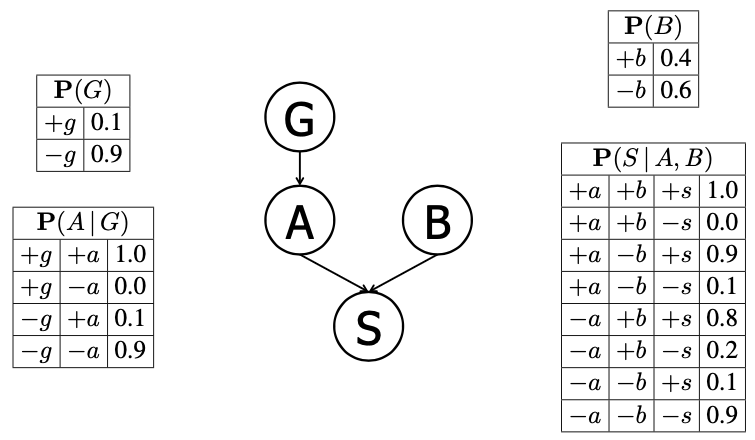

### 3-1

**[코드 작성]**

위 베이지안 네트워크를 실습 내용을 바탕으로 **코드로 구현**하시오.



In [ ]:
# cond prob table -> bayesian network
# G node has no parents
G = Node(DiscreteDistribution({
    "+g": 0.1,
    "-g": 0.9
}), name="G")
G.distribution.name = 'G'

# A node is conditional on G
A = Node(ConditionalProbabilityTable([
    ["+g", "+a", 1.0],
    ["+g", "-a", 0],
    ["-g", "+a", 0.1],
    ["-g", "-a", 0.9]
], [G.distribution]), name="A")

# B node has no parents
B = Node(DiscreteDistribution({
    "+b": 0.4,
    "-b": 0.6
}), name="B")
B.distribution.name = 'B'

# S node is conditional on A & B
S = Node(ConditionalProbabilityTable([
    ["+a", "+b", "+s", 1.0],
    ["+a", "+b", "-s", 0],
    ["+a", "-b", "+s", 0.9],
    ["+a", "-b", "-s", 0.1],
    ["-a", "+b", "+s", 0.8],
    ["-a", "+b", "-s", 0.2],
    ["-a", "-b", "+s", 0.1],
    ["-a", "-b", "-s", 0.9]
], [A.distribution, B.distribution]), name="S")

# Create a Bayesian Network and add states
model = BayesianNetwork()
model.add_states(G, A, B, S)

# Add edges connecting nodes
model.add_edge(G, A)
model.add_edge(A, S)
model.add_edge(B, S)

# Finalize model
model.bake()

### 3-2

**[코드 작성]**

3-1에서 구현한 베이지안 네트워크를 사용하여 아래 확률들을 출력하시오.

a. joint probability $P(+g, +a, +b, +s)$

b. 환자가 질병 $B$가 이미 있을 때 질병 $A$에 걸렸을 확률 (probability that a patient has disease $A$ given that they have disease $B$)

c. 환자가 질병 $A$을 이미 가지고 있을 때 질병 발현 유전자 변이 $G$을 가질 확률 (probability that a patient has the disease-carrying gene variation $G$ given that they have disease $A$)

d. 환자가 질병 $B$을 이미 가지고 있을 때 질병 발현 유전자 변이 $G$을 가질 확률 (probability that a patient has the disease-carrying gene variation $G$ given that they have disease $B$)

e. 환자가 질병 발현 유전자 변이 $G$을 이미 가지고 있을 때 증상 $S$가 발현될 확률 (probability that a patient has symptom $S$ given that they have disease-carrying gene variation $G$)

f. 환자가 증상 $S$가 발현했을 때 질병 발현 유전자 변이 $G$을 가질 확률 (probability that a patient has disease-carrying gene variation $G$ given that they have symptom $S$ )

In [ ]:
# use predict_proba
# a
model.probability([['+g', '+a', '+b', '+s']])

0.04000000000000001

In [ ]:
# b
predictions = model.predict_proba({
    'B':'+b'
})

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

G
    +g: 0.1000
    -g: 0.9000
A
    -a: 0.8100
    +a: 0.1900
B: +b
S
    -s: 0.1620
    +s: 0.8380


P(+a|+b) = 0.1900

In [ ]:
# c

predictions = model.predict_proba({
    'A':'+a'
})

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

G
    +g: 0.5263
    -g: 0.4737
A: +a
B
    +b: 0.4000
    -b: 0.6000
S
    -s: 0.0600
    +s: 0.9400


P(+g|+a) = 0.5263

In [ ]:
# d

predictions = model.predict_proba({
    'B':'+b'
})

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

G
    +g: 0.1000
    -g: 0.9000
A
    -a: 0.8100
    +a: 0.1900
B: +b
S
    -s: 0.1620
    +s: 0.8380


P(+g|+b) = 0.1000

In [ ]:
# e

predictions = model.predict_proba({
    'G':'+g'
})

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

G: +g
A
    -a: 0.0000
    +a: 1.0000
B
    +b: 0.4000
    -b: 0.6000
S
    -s: 0.0600
    +s: 0.9400


P(+s|+g) = 0.9400



In [ ]:
# f

predictions = model.predict_proba({
    'S':'+s'
})

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

G
    +g: 0.1933
    -g: 0.8067
A
    -a: 0.6328
    +a: 0.3672
B
    +b: 0.6891
    -b: 0.3109
S: +s


P(+g|+s) = 0.1933

## 4번: Extra Credit

우주의 외계인을 연구하는 생물학자가 있다. 이 생물학자의 전문 분야는 춤이며 외계인들이 춤을 발명하는 방식에 대한 베이지안 네트워크를 가지고 있다. 네트워크의 변수는 다음과 같다. There is a biologist who studies aliens in space. This biologist's specialty is dance and has a Bayesian network of the ways aliens invented dance. Variables in the network are as follows.

*  소리 감지(S): 외계인의 소리 감지 능력 유무
*  한랭 기후(C): 외계인의 고유 행성이 한랭한지 여부
*  음악(M): 외계인의 음악 발명 여부
*  비언어적 의사소통(N): 비언어적 의사소통의 형태가 있는지 여부
* Sound detection (S): presence or absence of alien sound detection capabilities
* Cold climate (C): whether the alien's endemic planet is cold
* Music (M): Whether Alien invented music or not
* Nonverbal communication (N): whether there is a form of nonverbal communication

아래 베이지안 네트워크는 위의 변수들과 춤(D) 사이의 관계를 표현한다. The Bayesian network below expresses the relationship between the above variables and dance (D).

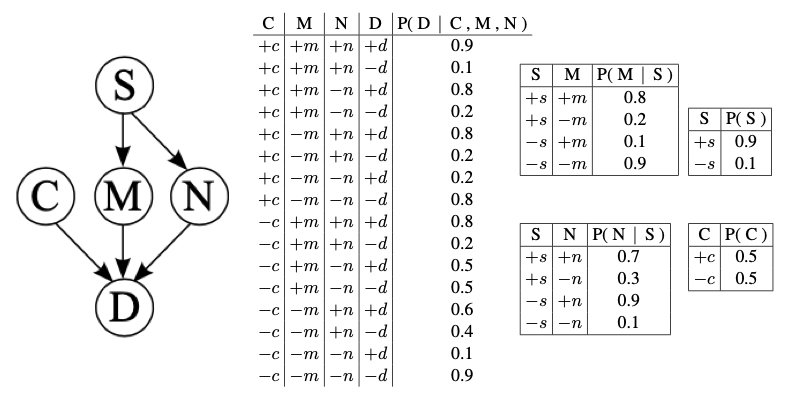

### 4-1

**[텍스트 작성]**

생물학자는 춤을 추고 소리를 감지하는 외계인이 음악을 발명하지 않을 가능성이 얼마나 되는지 알고 싶어 하며, approximate inference을 통해 계산하고자 한다. 아래는 prior sampling으로 생성된 샘플들이다. Biologists want to know how likely it is that aliens who dance and detect sounds will not invent music, and they want to calculate it through approximate information. Below are samples generated by prior sampling.


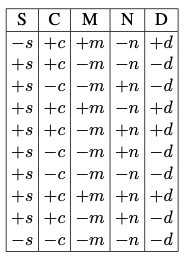

해당 샘플에 rejection sampling을 적용했을 때, 쿼리 $P (−m | +d, +s)$에 대한 답은 무엇인가? What is the answer to query $P (-m | +d, +s)$ when we apply the rejection sampling to that sample?

$P (-m | +d, +s)$ = 1/3

### 4-2

**[텍스트 작성]**

Rejection sampling은 대부분 잘 작동하지만 생물학자가 소리 감지 능력이 없는 외계인($P(-s) = 0.1$)에 대한 추론을 진행할 경우 대부분의 샘플들을 reject하기에 상대적으로 정확성이 떨어진다. 따라서 likelihood weighting을 사용하기로 한다. 소리 감지 능력이 없고 춤이 없는 외계인이 음악을 발명할 확률을 계산하고자 한다($P(+m | -s, -d)$). 아래 네 개 샘플들에 대한 weight을 계산하시오. Rejection sampling works mostly well, but when biologists make inference about aliens ($P(-s) = 0.1$) without sound detection capability, they are relatively less accurate to reject most samples. Therefore, we choose to use likelihood weighting. We want to calculate the probability that aliens without sound detection capability and without dance invent music ($P(+m | -s, -d)$. Calculate the weight for the four samples below.

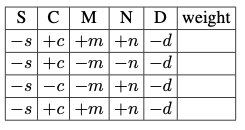

from distribution = 0.1 * 0.1 (2nd line of left table) for first
a+b+c+d / a+d

For sample 1,
P(-s) = 0.1
P(-d | +c, +m, -n) = 0.1
Total weight = 0.1*0.1 = 0.01

For sample 2,
P(-s) = 0.1
P(-d | +c, -m, -n) = 0.8
Total weight = 0.1*0.8 = 0.08

For sample 3,
P(-s) = 0.1
P(-d | -c, -m, +n) = 0.4
Total weight = 0.1*0.4 = 0.04

For sample 4,
P(-s) = 0.1
P(-d | +c, +m, +n) = 0.1
Total weight = 0.1*0.1 = 0.01

### 4-3

**[텍스트 작성]**

위 샘플들에 대해 likelihood weighting을 사용하여 쿼리 $P(+m | -s, -d)$을 계산하시오.

$P(+m | -s, -d)$ = 0.01*0.01 / (0.01+0.08+0.04+0.01) = 0.000714

### 4-4

**[코드 작성]**

위 베이지안 네트워크를 코드로 구현하고, rejection sampling을 사용하여 $P (M | +d, +s)$을 계산하고, likelihood weighting을 사용하여 $P(M | -s, -d)$을 계산하시오. `N=10000`을 사용하고 출력된 결과를 문제 상황에 맞게 해석하시오. Implement the above Bayesian network in code, calculate $P(M | +d, +s)$ using rejection sampling, and calculate $P(M | -s, -d)$ using likelihood weighting. Use 'N=10000' to interpret the output to the problem situation.

In [ ]:
# S node has no parents
S = Node(DiscreteDistribution({
    "+s": 0.9,
    "-s": 0.1
}), name="S")
G.distribution.name = 'S'

# C node has no parents
C = Node(DiscreteDistribution({
    "+c": 0.5,
    "-c": 0.5
}), name="C")
G.distribution.name = 'C'

# M node is conditional on S
M = Node(ConditionalProbabilityTable([
    ["+s", "+m", 0.8],
    ["+s", "-m", 0.2],
    ["-s", "+m", 0.1],
    ["-s", "-m", 0.9]
], [S.distribution]), name="M")

# N node is conditional on S
N = Node(ConditionalProbabilityTable([
    ["+s", "+n", 0.7],
    ["+s", "-n", 0.3],
    ["-s", "+n", 0.9],
    ["-s", "-n", 0.1]
], [S.distribution]), name="N")

# D node is conditional on C, M, N
D = Node(ConditionalProbabilityTable([
    ["+c", "+m", "+n", "+d", 0.9],
    ["+c", "+m", "+n", "-d", 0.1],
    ["+c", "+m", "-n", "+d", 0.8],
    ["+c", "+m", "-n", "-d", 0.2],
    ["+c", "-m", "+n", "+d", 0.8],
    ["+c", "-m", "+n", "-d", 0.2],
    ["+c", "-m", "-n", "+d", 0.2],
    ["+c", "-m", "-n", "-d", 0.8],
    ["-c", "+m", "+n", "+d", 0.8],
    ["-c", "+m", "+n", "-d", 0.2],
    ["-c", "+m", "-n", "+d", 0.5],
    ["-c", "+m", "-n", "-d", 0.5],
    ["-c", "-m", "+n", "+d", 0.6],
    ["-c", "-m", "+n", "-d", 0.4],
    ["-c", "-m", "-n", "+d", 0.1],
    ["-c", "-m", "-n", "-d", 0.9]
], [C.distribution, M.distribution, N.distribution]), name="D")

# Create a Bayesian Network and add states
model = BayesianNetwork()
model.add_states(S, C, M, N, D)

# Add edges connecting nodes
model.add_edge(S, M)
model.add_edge(S, N)
model.add_edge(C, D)
model.add_edge(M, D)
model.add_edge(N, D)

# Finalize model
model.bake()

In [ ]:
N = 10000
data = []

# Rejection sampling
for i in range(N):
  sample = generate_sample()
  if sample["S"] == "-s" and sample["D"] == "-d": # only append for evidence we want
    data.append(sample["M"])

print(Counter(data))

# normalize
x = Counter(data)
total = sum(x.values(), 0.0)
for key in x:
  x[key] /= total

print(x)

Counter({'-m': 328, '+m': 22})
Counter({'-m': 0.9371428571428572, '+m': 0.06285714285714286})


In [ ]:
# Likelihood weighting
parents_model = {'M': ['S'], 'N': ['S'], 'D': ['C', 'M', 'S']}
weighted = {'+m':0, '-m':0}
evidence = {'S':'-s'}

for i in range(N):
  sample, weight = generate_weighted_sample(evidence)
  if sample['S'] == '-s' and sample['D'] == '-d':
    weighted[sample['M']] += weight

print(weighted)

{'+m': 99.8999999999986, '-m': 900.1000000001361}


In [ ]:
# normalize
x = Counter(data)
total = sum(x.values(), 0.0)
for key in x:
  x[key] /= total

print(x)

Counter({'-m': 0.9371428571428572, '+m': 0.06285714285714286})
